# Maximum Likelihood Estimation 



In [1]:
# silent warnings
import warnings
warnings.filterwarnings('ignore')

# import libraries
import numpy as np, pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
import scipy.stats as stats
import statsmodels.api as sm
%matplotlib inline


In [2]:
# generate data
N = 100
x = np.linspace(0,20,N)
ϵ = np.random.normal(loc = 0.0, scale = 5.0, size = N)
y = 3*x + ϵ

# dump into a pandas DataFrame
df = pd.DataFrame({'y':y, 'x':x})
df['constant'] = 1

In [3]:
# observe a few data points
df.head()

,y,x,constant
0,-11.238261,0.000000,1
1,-11.111171,0.202020,1
2,-6.139536,0.404040,1
3,-4.942599,0.606061,1
4,0.952223,0.808081,1


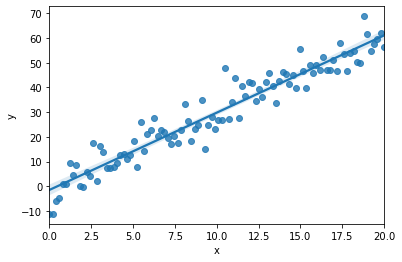

In [4]:
# plot the data and fitting a regression line 
# confidence intervals are also displayed
sns.regplot(df.x, df.y);

## Modeling OLS with Statsmodels

Since we created regression-like, continuous data, we will use sm.OLS to calculate the best coefficients and Log-likelihood (LL) as a benchmark.

In [5]:
# split features and target
X = df[['constant', 'x']]

# fit model and summarize
sm.OLS(y,X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.922
Method:                 Least Squares   F-statistic:                     1165.
Date:                Thu, 10 Sep 2020   Prob (F-statistic):           3.37e-56
Time:                        23:25:21   Log-Likelihood:                -308.64
No. Observations:                 100   AIC:                             621.3
Df Residuals:                      98   BIC:                             626.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
constant      -1.5347      1.062     -1.444      0.152      -3.643       0.574
x              3.1324      0.092     34.129      0.000       2.950       3.315
==============================================================================
Omnibus:                        5.111   Durbin-Watson:                   2.092
Prob(Omnibus):                  0.078   Jarque-Bera (JB):                4.574
Skew:                           0.510   Prob(JB):                        0.102
Kurtosis:                       3.240   Cond. No.                         23.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Maximizing LL to solve for Optimal Coefficients

From here, we’ll use a combination of packages and custom functions to see if we can calculate the same OLS results above using MLE methods.
Because scipy.optimize has only a minimize method, we'll minimize the negative of the log-likelihood. This is even what they recommend! Math trickery is often faster and easier than re-inventing the wheel!
We can build a simple function that does everything in one pass for regression outputs:

In [6]:
# define likelihood function
def MLERegression(params):
    intercept, beta, sd = params[0], params[1], params[2] # inputs are guesses at our parameters
    yhat = intercept + beta*x # predictions
    
    # next, we flip the Bayesian question
    # compute PDF of observed values normally distributed around mean (yhat)
    # with a standard deviation of sd
    negLL = -np.sum( stats.norm.logpdf(y, loc=yhat, scale=sd) )
    
    # return negative LL
    return(negLL)


In [7]:
# let’s start with some random coefficient guesses and optimize
guess = np.array([5,5,2])

results = minimize(MLERegression, guess, method = 'Nelder-Mead', options={'disp': True})

Optimization terminated successfully.
         Current function value: 308.635417
         Iterations: 118
         Function evaluations: 212


In [8]:
results # this gives us verbosity around our minimization
# notice our final key and associated values

 final_simplex: (array([[-1.53467898,  3.1323903 ,  5.29845061],
       [-1.53475329,  3.13239614,  5.29845639],
       [-1.5346662 ,  3.13238943,  5.29846112],
       [-1.53470413,  3.13239065,  5.29845562]]), array([308.63541747, 308.63541747, 308.63541747, 308.63541747]))
           fun: 308.63541747003626
       message: 'Optimization terminated successfully.'
          nfev: 212
           nit: 118
        status: 0
       success: True
             x: array([-1.53467898,  3.1323903 ,  5.29845061])

In [9]:
# drop results into df and round to match statsmodels
resultsdf = pd.DataFrame({'coef':results['x']})
resultsdf.index=['constant','x','sigma']   
np.round(resultsdf.head(2), 4)

# do our numbers match the OLS model?

,coef
constant,-1.5347
x,3.1324
